In [13]:
import numpy as np
import matplotlib.pyplot as pt
import pandas as pd
import statsmodels.stats.outliers_influence as oi
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from scipy import interp

import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df=pd.read_csv('Churn.csv')


In [14]:
"""----------------------------DATA PREPARATION--------------------------"""

for i in df.columns:
    df[i]=df[i].replace(" ",np.NaN)
    
#print (df.isnull().sum())

    
df.dropna(inplace=True)
df = df.reset_index()[df.columns]
#print (df.isnull().sum())
'''def tenure_lab(t) :
    
    if t <= 12 :
        return 1
    elif (t > 12) & (t <= 24 ):
        return 2
    elif (t > 24) & (t <= 48) :
        return 3
    elif (t > 48) & (t <= 60) :
        return 4
    elif t > 60 :
        return 5

df["tenure"]=df["tenure"].map(tenure_lab)'''


#since we have 72 categories in tenure we will reduce the number of categories in it
#therefoe we made above function and to check how many categories each column has now,we are using the following loop

for c_n in df.columns:
    #print c_n
   # if X[c_n]=='object' :
    unique_cat=df[c_n].nunique()
    #print ("Feature", c_n,"has", unique_cat,"unique categories")


X=df.drop('Churn',1)
Y=df.Churn

X=X.drop('customerID',1)

todummy_list  =X.nunique()[X.nunique() < 6].keys().tolist()

num_cols   = [x for x in X.columns if x not in todummy_list]
'''todummy_list.remove('tenure')
num_cols.insert(3,'tenure')'''
X_org=X.copy()

for i in todummy_list:
    dummies= pd.get_dummies(X[i],prefix=i)
    #print dummies
    #dummies=dummies.iloc[:,1:]
    X=X.drop(i,1)
    X=pd.concat([dummies,X],axis=1)
X=X.drop(['StreamingTV_No internet service','StreamingMovies_No internet service','TechSupport_No internet service','DeviceProtection_No internet service','OnlineBackup_No internet service'],axis=1)


In [15]:
def roc_plot(clf_obj,x_test,y_test,predictions):
    
    # all parameters not specified are set to their defaults
    fpr, tpr, thresholds = roc_curve(y_test, predictions)

    #plot no skill
    from matplotlib import pyplot
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    # show the plot
    pyplot.show()

    auc = roc_auc_score(y_test, predictions)
    print('AUC: %.3f' % auc)
    
    import seaborn as sns
        
    cm = metrics.confusion_matrix(y_test, predictions)
    score = clf_obj.score(x_test, y_test)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title =' Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);

In [16]:
le = LabelEncoder()
Y= le.fit_transform(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)    
from sklearn.preprocessing import StandardScaler
# Fitting parameters for scaling x_train for the numerical columns 
std = StandardScaler().fit(x_train[num_cols])
#Transforming the the original data
x_train_transformed=std.transform(x_train[num_cols])
x_train_transformed_df = pd.DataFrame(x_train_transformed,columns=num_cols)
x_train=x_train.drop(num_cols,1)
x_train=pd.concat([x_train.reset_index(drop=True),x_train_transformed_df.reset_index(drop=True) ],axis=1)

#Transforming the the test data's numerical with x_train scaled parameters
x_test_transformed=std.transform(x_test[num_cols])
x_test_transformed_df = pd.DataFrame(x_test_transformed,columns=num_cols)
x_test=x_test.drop(num_cols,1)
x_test=pd.concat([x_test.reset_index(drop=True),x_test_transformed_df .reset_index(drop=True) ],axis=1)


In [31]:
from sklearn.model_selection import GridSearchCV


from xgboost.sklearn import XGBClassifier

xgb1 = XGBClassifier()
gs = GridSearchCV(xgb1,param_grid={'learning_rate':[0.01],'n_estimators':[140,200,500,1000,1500,2000,2500],'max_depth':[1],'min_child_weight':[1],'gamma':[0],'subsample':[0.25],'colsample_bytree':[0.6],'reg_alpha':[1e-3]},scoring='roc_auc')


gs.fit(x_train,y_train)


means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
c=0
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    c=c+1
    print("%d) %0.3f (+/-%0.03f) for %r"% (c,mean, std * 2, params))

print("Best score: %0.4f" % gs.best_score_)

print("Best parameters:\n",gs.best_params_)


print("Best estimator:\n",gs.best_estimator_)


1) 0.836 (+/-0.014) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 140, 'reg_alpha': 0.001, 'subsample': 0.25}
2) 0.838 (+/-0.016) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.001, 'subsample': 0.25}
3) 0.845 (+/-0.015) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.001, 'subsample': 0.25}
4) 0.850 (+/-0.015) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0.001, 'subsample': 0.25}
5) 0.851 (+/-0.014) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 1500, 'reg_alpha': 0.001, 'subsample': 0.25}
6) 0.852 (+/-0.014) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate':

In [28]:
gs.fit(x_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1], 'n_estimators': [140], 'max_depth': [1], 'min_child_weight': [1], 'gamma': [0], 'subsample': [0.25], 'colsample_bytree': [0.6], 'reg_alpha': [0, 0.001, 0.005, 0.008, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

1) 0.851 (+/-0.015) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 140, 'reg_alpha': 0, 'subsample': 0.25}
2) 0.851 (+/-0.015) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 140, 'reg_alpha': 0.001, 'subsample': 0.25}
3) 0.851 (+/-0.015) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 140, 'reg_alpha': 0.005, 'subsample': 0.25}
4) 0.851 (+/-0.015) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 140, 'reg_alpha': 0.008, 'subsample': 0.25}
5) 0.851 (+/-0.015) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 140, 'reg_alpha': 0.1, 'subsample': 0.25}
6) 0.851 (+/-0.015) for {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_de

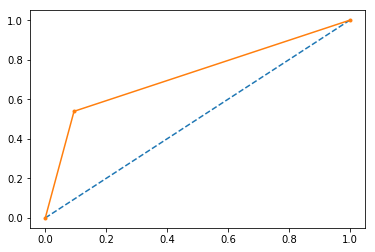

AUC: 0.722


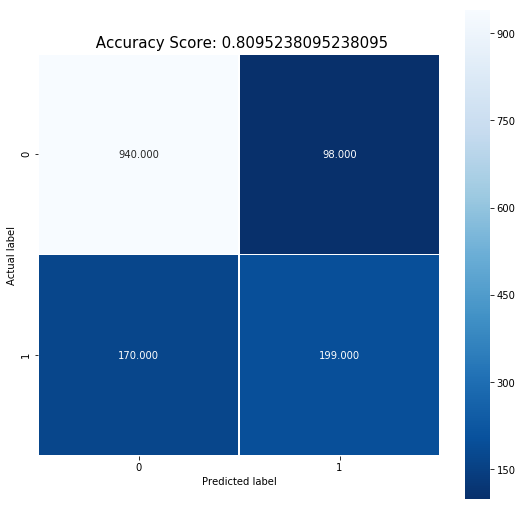

In [29]:



means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
c=0
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    c=c+1
    print("%d) %0.3f (+/-%0.03f) for %r"% (c,mean, std * 2, params))

print("Best score: %0.4f" % gs.best_score_)

print("Best parameters:\n",gs.best_params_)


print("Best estimator:\n",gs.best_estimator_)



rf=gs.best_estimator_

model= rf.fit(x_train,y_train)


pred=model.predict(x_test)

roc_plot(model,x_test,y_test,pred)